In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

The data sets used in this comparison where created by running standard data generation with clean data integrated based on secular timescale as specified in genTmaxData.ipynb. For each trial the specified multiple of secular time scale and integration dt was manually changed in spock source code

In [21]:
#load datapath for clean training data
datapath = '../../cleanData/csvs/resonant/dtTests/'
twoTsecData = ['2Tsec005dt.csv','2Tsec0055dt.csv','2Tsec006dt.csv','2Tsec0065dt.csv','2Tsec007dt.csv']
oneTsecData = ['1Tsec005dt.csv','1Tsec0055dt.csv','1Tsec006dt.csv','1Tsec0065dt.csv','1Tsec007dt.csv']

Features where generated for the entire dataset when integrating to the secular time scale, and to two times the secular timescale. The dt of the integration was varied to be x*minimum peri passing time, where x was varied from 0.05-0.07.

In [13]:
#here we will specify the features we will use
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno + ['Tmax']

We will define helper functions, taken from train_FC.ipynb

In [10]:
def train_test(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in 1e4 orbits

    test = test.drop(test[test['InitialStable']==False].index)
    return train[features], train['Stable'], test[features], test['Stable']

In [14]:
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

Here we will define a function that returns a models performance when trained and tested on a given datasheet by returning the AUC and the FPR when the TRP is 0.9

In [17]:
def getPerformance(datasheet):
    #we will first read the specified datasheet
    dataset = pd.read_csv(datasheet)
    dataset = dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1']) #we will drop junk columns
    #we can now split up the data into training and testing
    trainX, trainY, testX, testY = train_test(dataset, features)
    #define the dataset specific stable/unstable ratio
    trainingBalance = trainY.value_counts()[False]/trainY.value_counts()[True]
    # we will define a new XGBoost model using the parameters found for the normal integrations
    model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 10,
                         n_estimators = 125,
                         scale_pos_weight=trainingBalance)
    #we can now fit the model to training data
    model.fit(trainX,trainY)
    #determine the performance data
    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX, testY)
    #we will next determine the FPR when our TPR is 0.9
    tprthreshindex = np.where(tpr >=0.9)[0][0]
    falsePos = fpr[tprthreshindex]
    #return AUC and FPR
    return roc_auc,falsePos

We can now generate the results for each set of trials

In [23]:
%%time
dtList = [0.05,0.055,0.06,0.065,0.07]
TsecAUC = []
TsecFPR = []
twoTsecAUC = []
twoTsecFPR = []
#iterate through all Tsec data
for path in oneTsecData:
    auc,fpr = getPerformance(datapath+path)
    TsecAUC.append(auc)
    TsecFPR.append(fpr)
#iterate through all two Tsec data
for path in twoTsecData:
    auc,fpr = getPerformance(datapath+path)
    twoTsecAUC.append(auc)
    twoTsecFPR.append(fpr)

CPU times: user 1h 35min, sys: 2min 47s, total: 1h 37min 48s
Wall time: 1min 32s


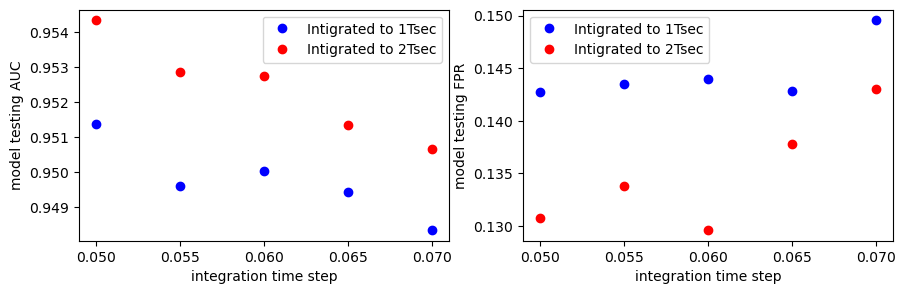

In [42]:
#We can plot our results
fig, (ax1, ax2) = plt.subplots(1, 2) 
ax1.plot(dtList, TsecAUC, 'o', c='b', label='Intigrated to 1Tsec')
ax1.plot(dtList, twoTsecAUC, 'o', c='r', label='Intigrated to 2Tsec')
ax1.set_xlabel('integration time step')
ax1.set_ylabel('model testing AUC')
ax1.legend()
ax2.plot(dtList, TsecFPR, 'o', c='b', label='Intigrated to 1Tsec')
ax2.plot(dtList, twoTsecFPR, 'o', c='r', label='Intigrated to 2Tsec')
ax2.set_xlabel('integration time step')
ax2.set_ylabel('model testing FPR')
ax2.legend()
fig.set_figheight(3)
fig.set_figwidth(10.5)

Given that integrating to two times the secular time scale is essentially twice as computationally expensive and takes significantly longer than integrating to 1e4, we have chosen to primarily consider tests which integrate to only one secular timescale

The time cost (inversely related to dt) to performance ratio when integrating to Tsec seems to be minimized when dt=0.065.

In [51]:
auc,fpr = getPerformance(datapath + oneTsecData[3])

In [52]:
print(f'When dt=0.065*minPeri, the model has a AUC of {auc} and a FPR (when TPR is 0.9) of {fpr}')

When dt=0.065*minPeri, the model has a AUC of 0.9494355110382595 and a FPR (when TPR is 0.9) of 0.1428172163219676


Note, when integrating to 1e4 orbits, the model performance can be denoted

1e4 AUC: 0.9436352768410051

1e4 FPR: 0.163252508361204

Additionally, on our in house computation cluster, generating the data for all 100k+ systems when integrating to the secular time scale with a dt of 0.065 takes about **22.3** minutes, while integrating to 1e4 orbits with a dt of 0.05 (old spock) takes **14** minutes. This represents an exchange of about 50% longer computation time in order to decrease FPR by two percentage points and increase AUC by 0.7 percentage points